# Raw Data Visualisation

In [1]:
import pandas as pd
import numpy as np

import csv
from tqdm import tqdm_notebook,tnrange,tqdm_pandas,tqdm
tqdm.pandas(tqdm())

import os
from dateutil import parser
import cPickle as pickle

# %matplotlib nbagg
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib import animation
from IPython.core.display import HTML
%matplotlib inline
import timeit
import time
import datetime as dt


import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
#notify if cell is finished for cells taking longer than 30 seconds
%autonotify -a 30

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

## Path to your urinal-data-28-nov_clean _pickle_ file

In [2]:
# pickle_name = "urinal-data-28-nov_clean.p"
# pickle_path = "F:\\Research\\ben\\grideye_urinal"
# pickle_full = os.path.join(pickle_path, pickle_name)

# print("looking in", pickle_full)
pickle_full = "urinal-data-28-nov_clean.p"

## Path to your urinal-data-28-nov_clean _pickle_ file

In [3]:
# csv_name = "urinal-data-28-nov_clean.csv"
# csv_path = "F:\\Research\\ben\\grideye_urinal"
# csv_full = os.path.join(csv_path, csv_name)

# print("looking in", csv_full)
csv_full = "urinal-data-28-nov_clean.csv"

## Clean Up Our Raw data for analyis

In [16]:
     
#---------- read in pick or read csv, cleanup, and create pickle----------   
if os.path.isfile(pickle_full):
    print("loading pickle")
    df = pd.read_pickle(pickle_full)
   
else:
    print("creating pickle...")
    print("this will take some time...")
    df = pd.read_csv(csv_full)
    df.columns = ["time"]+["P"+str(x) for x in range(64)]
    
    # remove dirty data
    df = df[[(x[:2] != "TT") for x in df["time"]]]
    df = df[[x[16:18] != ":S" for x in df["time"]]]
        
    # drop indexes where camera had fallen down/face was in camera
    df = df.drop(range(0,97710+14234), axis=0) #drop row
    df["time"] = df["time"].progress_apply(pd.to_datetime,format="%a %b %d %H:%M:%S %Y") + dt.timedelta(hours=10)
    df = df.set_index('time')
    
    #flip image
    cols = []
    for y in range(7,-1,-1):
            for x in range(8):
                cols.append(x*8+y)
            
    cols = ["P"+str(x) for x in cols] 
    df = df.reindex(columns=cols)
   
    # reset column names
    df.columns = ["P"+str(x) for x in range(64)]
        
    df.to_pickle(pickle_full)


loading pickle


## Visualise Our Data!
We have an 8x8 grid of thermal pixels: Seaborns heatmap is perfect here.
Below we'll look at a typical instance of a person walking in using the left urinal and leaving.
This particular person visited at 4 pm on a Friday

In [124]:
start = df.index.searchsorted(dt.datetime(2017, 11, 24, 15, 59,35,0))
end = df.index.searchsorted(dt.datetime(2017, 11, 24, 16,0,10,0))

### A Single Video Frame

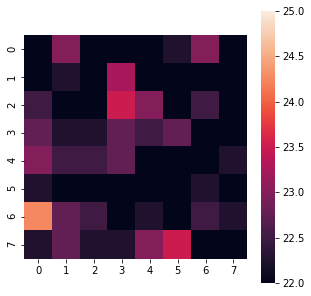

In [130]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (5,5)
# Person walking to middle: walk in - 9911 , walk out - 10198 df.iloc[9911:10198]
frames = []
for row in df.iloc[start:end].iterrows():
        frames.append(np.array(row[1]).reshape(8,8).astype('float'))

sns.heatmap(frames[-10], vmin=22, vmax=25,square=True)


### Animation of a Stay

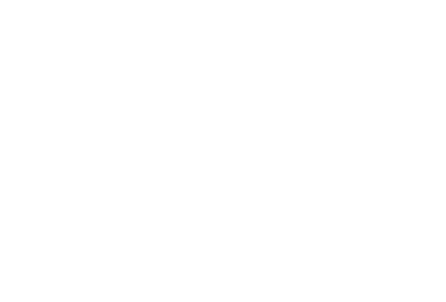

<IPython.core.display.Javascript object>

In [133]:
# Low res animation
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
plt.rcParams['animation.writer'] = 'ffmpeg'
# print(matplotlib.animation.writers.list())
from matplotlib import animation, rc
from IPython.display import HTML

# fig, ax = plt.subplots()
# fig.set_tight_layout(True)
fig = plt.figure()

def init():
    plt.clf()
    sns.heatmap(np.zeros((8, 8)),vmin=22,vmax=25,square=True)
    plt.clf()
#     return (sns,)

def animate(i):
    plt.clf()
    data = frames[i]
    sns.heatmap(data, vmin=22,vmax=25,square=True)
#     return (sns,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frames),interval=100,repeat=False)#,blit = True)
HTML(anim.to_html5_video())

#need to return a seaborn object with an "artist object"
#in order to use blit (and therefore speed up rendering)


You might have noticed how noisy the data is.
There are two main reasons for this.
1. The accuracy and precision of the Grideye is low (&pm;2.5&deg;C, and &pm;0.25&deg;C) <sup>[1](https://industrial.panasonic.com/cdbs/www-data/pdf/ADI8000/ADI8000C53.pdf)</sup>
2. Temperature varies in a ventilated (HVAC) system, often more than our mentioned precision <sup>[2](https://www.sciencedirect.com/science/article/pii/S0360132396000340)</sup>
 
Below we plot the mean temperature (of a video frame) per 10 minutes for all of our data.
(Later we'll see that a person almost never stays at a urinal for longer than 2 minutes)

### Plot mean temperature

In [137]:
temp_inst = df.mean(axis=1)

<IPython.core.display.Javascript object>

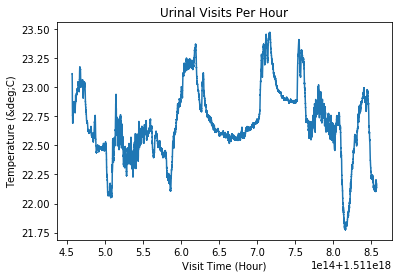

In [141]:
fs = 10
min1 = 60

fig, ax = plt.subplots()

ax.plot(df.index,temp_inst.rolling(window=10*min1*fs).mean())

# ax.set_xticks(range(0,len(hour_sums["hour"])));
# ax.set_xticklabels(my_xticks,rotation=90)

ax.set_xlabel('Visit Time (Hour)');
ax.set_ylabel('Temperature (&deg;C)');
ax.set_title('Urinal Visits Per Hour');

In [138]:
df.index

DatetimeIndex(['2017-11-23 16:56:59', '2017-11-23 16:56:59',
               '2017-11-23 16:56:59', '2017-11-23 16:56:59',
               '2017-11-23 16:56:59', '2017-11-23 16:56:59',
               '2017-11-23 16:57:00', '2017-11-23 16:57:00',
               '2017-11-23 16:57:00', '2017-11-23 16:57:00',
               ...
               '2017-11-28 08:22:14', '2017-11-28 08:22:14',
               '2017-11-28 08:22:14', '2017-11-28 08:22:14',
               '2017-11-28 08:22:14', '2017-11-28 08:22:14',
               '2017-11-28 08:22:14', '2017-11-28 08:22:14',
               '2017-11-28 08:22:15', '2017-11-28 08:22:15'],
              dtype='datetime64[ns]', name=u'time', length=3540394, freq=None)

In [90]:
600*60

36000